# Plot F-layer figures

This notebook makes the final two figures form the manuscript and part of the first figure. It does this by processing output files from a large batch of runs. See the README file for details of running all the cases.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import adjustText
%matplotlib inline

import plotting
import bulk_case_runner

## Process all slurry cases and report basic information

We've run a grid of different $\Delta T_{ICB}$, $\Delta X_{ICB}$, $I_0$, $D_L$ and $\mu$
so our first step is to find the $\Delta T_{ICB}$ and $\Delta X_{ICB}$ that give
6 TW of heat production and 27 kg/m^3 of densitiy difference compared to the adiabat
for each set fixed $I_0$, $D_L$ and $\mu$. Not all choices of these parameters produce
'viable' models.

In [2]:
target_density_excess = 27.24 # This is prem - ak135f
target_latent_heat = 6.0*1.0E12 # W ... see arguments in manuscript

basepath = pathlib.Path('./cases/')
filename = "grid.csv"

In [3]:


red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

# Dimond - high nuc rate
# Circle - med nuc rate
# square - low nuc rate

data = [{'dir': 'i0_1E-11_dl_1E-11_mu_3E-05',
         'color': red, 'm': 's', 'desc': 'red square'},
        {'dir': 'i0_1E-07_dl_1E-11_mu_3E-05',
         'color': red, 'm': 'D', 'desc': 'red diamond'},
        {'dir': 'i0_1E-09_dl_1E-11_mu_3E-05',
         'color': red, 'm': 'o', 'desc': 'red circle'},
        {'dir': 'i0_1E-10_dl_1E-11_mu_3E-05',
         'color': red, 'm': 'h', 'desc': 'red hexagon'},
        {'dir': 'i0_1E-08_dl_1E-11_mu_3E-05',
         'color': red, 'm': '*', 'desc': 'red star'},
        {'dir': 'i0_1E-11_dl_1E-11_mu_6E-08',
         'color': orange, 'm': 's', 'desc': 'orange square'},
        {'dir': 'i0_1E-07_dl_1E-11_mu_6E-08',
         'color': orange, 'm': 'D', 'desc': 'orange diamond'},
        {'dir': 'i0_1E-09_dl_1E-11_mu_6E-08',
         'color': orange, 'm': 'o', 'desc': 'orange circle'},
        {'dir': 'i0_1E-10_dl_1E-11_mu_6E-08',
         'color': orange, 'm': 'h', 'desc': 'orange hexagon'},
        {'dir': 'i0_1E-08_dl_1E-11_mu_6E-08',
         'color': orange, 'm': '*', 'desc': 'orange star'},
        {'dir': 'i0_1E-11_dl_1E-11_mu_2E-06',
         'color': yellow, 'm': 's', 'desc': 'yellow square'},
        {'dir': 'i0_1E-07_dl_1E-11_mu_2E-06',
         'color': yellow, 'm': 'D', 'desc': 'yellow diamond'},
        {'dir': 'i0_1E-09_dl_1E-11_mu_2E-06',
         'color': yellow, 'm': 'o', 'desc': 'yellow circle'},
        {'dir': 'i0_1E-10_dl_1E-11_mu_2E-06',
         'color': yellow, 'm': 'h', 'desc': 'yellow hexagon'},
        {'dir': 'i0_1E-08_dl_1E-11_mu_2E-06',
         'color': yellow, 'm': '*', 'desc': 'yellow star'},
        {'dir': 'i0_1E-11_dl_1E-09_mu_2E-06',
         'color': light_blue, 'm': 's', 'desc': 'light blue square'},
        {'dir': 'i0_1E-07_dl_1E-09_mu_2E-06',
         'color': light_blue, 'm': 'D', 'desc': 'light blue diamond'},
        {'dir': 'i0_1E-09_dl_1E-09_mu_2E-06',
         'color': light_blue, 'm': 'o', 'desc': 'light blue circle'},
        {'dir': 'i0_1E-10_dl_1E-09_mu_2E-06',
         'color': light_blue, 'm': 'h', 'desc': 'light blue hexagon'},
        {'dir': 'i0_1E-08_dl_1E-09_mu_2E-06',
         'color': light_blue, 'm': '*', 'desc': 'light blue star'},
        {'dir': 'i0_1E-11_dl_1E-12_mu_2E-06',
         'color': dark_blue, 'm': 's', 'desc': 'dark blue square'},
        {'dir': 'i0_1E-07_dl_1E-12_mu_2E-06',
         'color': dark_blue, 'm': 'D', 'desc': 'dark blue diamond'},
        {'dir': 'i0_1E-09_dl_1E-12_mu_2E-06',
         'color': dark_blue, 'm': 'o', 'desc': 'dark blue circle'},
        {'dir': 'i0_1E-10_dl_1E-12_mu_2E-06',
         'color': dark_blue, 'm': 'h', 'desc': 'dark blue hexagon'},
        {'dir': 'i0_1E-08_dl_1E-12_mu_2E-06',
        'color': dark_blue, 'm': '*', 'desc': 'dark blue star'}]

all_matches = None # Dataframe if we get a crossing
fallback_case = 'case_-50.0_0.0125.pkl' # for extra data even if no match
all_cases = [] # Will be a dataframe for reporting as LaTeX table

for thisdata in data:
    print(thisdata["dir"])
    print(thisdata["desc"])
    summary_file = basepath / thisdata["dir"] / filename
    summary_df = pd.read_csv(summary_file)
    
    lx, lt = plotting._get_dt_dx_both(summary_df, target_latent_heat=target_latent_heat, 
                            target_density_excess=target_density_excess)
    print("Best x:", lx, "best T:", lt)
    match = summary_df[(summary_df["dt"] == lt) & 
                       (summary_df["dx"] == lx)].copy()
    latent_heat = match["total_latent_heat"].values[0] / 1.0E12 # TW
    excess_density = match.liquid_density_excess.values[0] + \
        match.max_solid_excess_density.fillna(0).values[0]
    print(f"Latent heat: {latent_heat} TW")
    print(f"Excess density: {excess_density} kg m^-3")
    if ((abs(excess_density - target_density_excess) < 2.0) and 
        (abs(latent_heat - target_latent_heat) < 6.0E12) and
        (latent_heat > 1.0)):
        print("OK")
        match["color"] = thisdata["color"]
        match["marker"] = thisdata["m"]
        full_file = basepath / thisdata["dir"] / f"detailed_output/case_{lt}_{lx}.pkl"
        match["full_file"] = str(full_file)
        match["summary_file"] = str(summary_file)
        detailed_data = bulk_case_runner.load_case_data(full_file)
        eta = detailed_data["kinematic_viscosity"]
        dl = detailed_data["chemical_diffusivity"]
        i0 = detailed_data["i0"]
        all_cases.append({'$D^L$': dl, '$\eta^L$': eta, '$I_0$': i0, 
                          '$\Delta T_{ICB}$': lt, '$\Delta X_{ICB}$': lx,
                          r'$Q^F$': latent_heat,
                          r'$\Delta \rho$': excess_density,
                          '$G_{ICB}$': detailed_data["growth_rate"], 
                          '$\max r_p$': np.nanmax(detailed_data["particle_radii"]),
                          '$\max I$': np.nanmax(detailed_data["nucleation_rates"]),
                          '$\max \phi$': np.nanmax(detailed_data["solid_vf"]),
                          'Symbol': thisdata["desc"]})
        match["kinematic_viscosity"] = detailed_data["kinematic_viscosity"]
        match["chemical_diffusivity"] = detailed_data["chemical_diffusivity"]
        match["i0"] = detailed_data["i0"]
        if all_matches is None:
            all_matches = match
        else:
            all_matches = pd.concat([all_matches,match])
            
    else:
        print("NOT OK")
        # We can always read input parameters from here...
        fallback_file = basepath / thisdata["dir"] / "detailed_output/case_-50.0_0.0125.pkl"
        detailed_data = bulk_case_runner.load_case_data(fallback_file)
        eta = detailed_data["kinematic_viscosity"]
        dl = detailed_data["chemical_diffusivity"]
        i0 = detailed_data["i0"]
        all_cases.append({'$D^L$': dl, '$\eta^L$': eta, '$I_0$': i0, 
                          '$\Delta T_{ICB}$': '--', '$\Delta X_{ICB}$': '--',
                          r'$Q^F$': '--', r'$\Delta \rho$': '--',
                          '$G_{ICB}$': '--', '$\max r_p$': '--',
                          '$\max I$': '--', '$\max \phi$': '--', 'Symbol': thisdata["desc"]})
    

print(pd.DataFrame(all_cases).to_latex(float_format="{:0.3g}".format, index=False))

i0_1E-11_dl_1E-11_mu_3E-05
red square
Best x: 0.00625 best T: -65.0
Latent heat: 0.12416835182339296 TW
Excess density: 26.278166164554932 kg m^-3
NOT OK
i0_1E-07_dl_1E-11_mu_3E-05
red diamond
Best x: 0.01 best T: 50.0
Latent heat: 6.054996732567291 TW
Excess density: 26.594680545871597 kg m^-3
OK
i0_1E-09_dl_1E-11_mu_3E-05
red circle
Best x: 0.008125 best T: -20.0
Latent heat: 6.004454838368143 TW
Excess density: 27.695933944100034 kg m^-3
OK
i0_1E-10_dl_1E-11_mu_3E-05
red hexagon
Best x: 0.00625 best T: -65.0
Latent heat: 1.239181144196245 TW
Excess density: 26.27816636060379 kg m^-3
OK
i0_1E-08_dl_1E-11_mu_3E-05
red star
Best x: 0.009375 best T: 30.0
Latent heat: 5.7901786519755465 TW
Excess density: 26.62587044128304 kg m^-3
OK
i0_1E-11_dl_1E-11_mu_6E-08
orange square
Best x: 0.00625 best T: -65.0
Latent heat: 0.9994313452695192 TW
Excess density: 26.278166177755338 kg m^-3
NOT OK
i0_1E-07_dl_1E-11_mu_6E-08
orange diamond
Best x: 0.01 best T: 45.0
Latent heat: 6.376931127779896 TW


## Make the figures

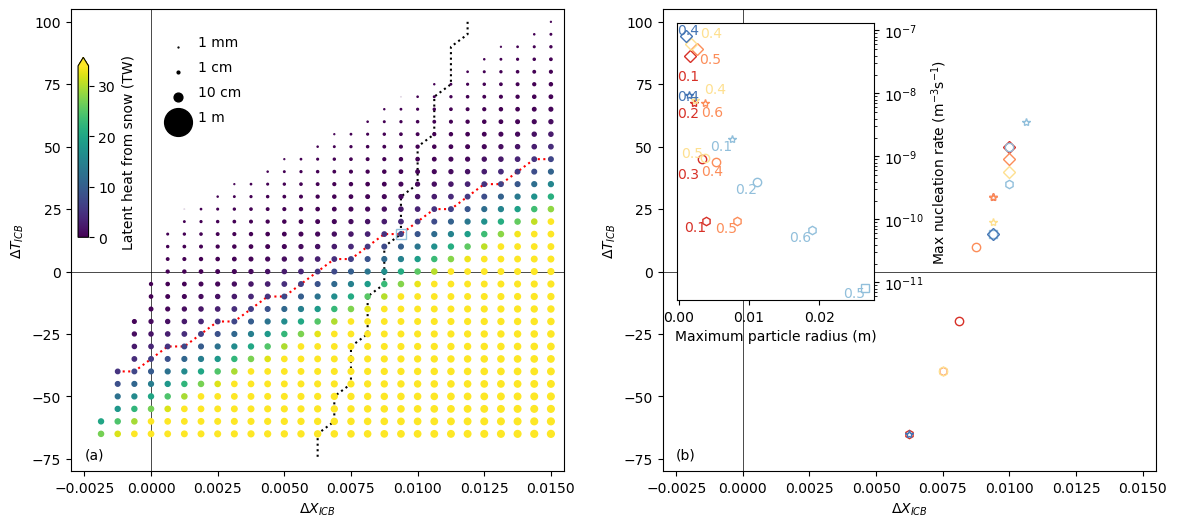

BV freq = 0.00022808372865804213
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Temperature at CMB: 1565.182533320402 K
Liquid density at ICB: 12793.069399185762 Kg/m^3
Liquid density at top of F-layer 12541.75854788575 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768384 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104026 Kg/m^3
Liquid density difference at ICB: 28.13822941737817 Kg/m^3


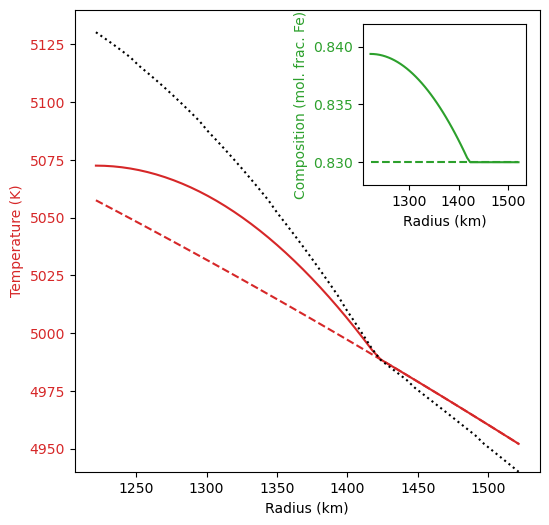

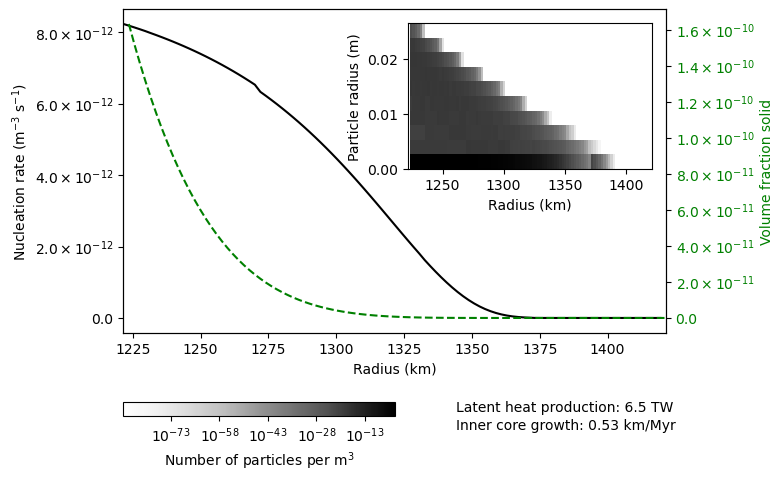

In [4]:
 # Which imput parameters to plot...
    
kinematic_viscosity = 2.0E-6
chemical_diffusivity = 1.0E-9
i0 = 1.0E-11

# Will fail if the input parameters did not produce an 'earth like' model.
case = all_matches.loc[(all_matches["kinematic_viscosity"] == kinematic_viscosity) & 
                       (all_matches["chemical_diffusivity"] == chemical_diffusivity) & 
                       (all_matches["i0"] == i0)]


summary_file_name = case["summary_file"].values[0]
summary_df = pd.read_csv(summary_file_name)

# Get best latent heat and temperature on grid
lx, lt = plotting._get_dt_dx_both(summary_df, target_latent_heat=target_latent_heat, 
                            target_density_excess=target_density_excess)

# Make the plot
fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
ax3 = fig.add_axes([0.13, 0.5, 0.0075, 0.3])
plotting.plot_summary_figure(summary_df, target_latent_heat=target_latent_heat, 
                    target_density_excess=target_density_excess, marker_x=lx,
                    marker_t=lt, marker=case["marker"].values[0], marker_color=case["color"].values[0],
                    include_fails=False, fig=fig, ax=ax1, noplot=True, cax=ax3)
ax1.text(-0.0025, -75, '(a)')

plotting.plot_matches(all_matches, fig=fig, ax=ax2, noplot=True)
ax2.text(-0.0025, -75, '(b)')
plt.show()

# Get hold of the detailed data
data = bulk_case_runner.load_case_data(case["full_file"].values[0])

# Plot the temperature and composition
plotting.make_layer_plot(lt, lx, data["xfe_outer_core"])

# Plot the CSD
plotting.plot_case_figure(data)

